[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vmetsis/cads-cv/blob/main/2.3-filters.ipynb)

# Filters

In this notebook we will see how to apply filters to images. Filters are used to enhance or reduce certain features in an image. We will see how to apply blurring and sharpening filters to images.

## Download the Data

In [1]:
# If running on Google Colab, download the data first.

import os
import sys

def download_files(base_url, files, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    for file in files:
        file_url = base_url + file
        os.system(f"wget -q {file_url} -P {local_dir}")

def download_data():
    base_url = "https://raw.githubusercontent.com/vmetsis/cads-cv/main/data/"
    data_files = ["sunset.jpg", "Illinois_highway.mp4", "sharpen.jpg"]
    
    download_files(base_url, data_files, 'data')

if 'google.colab' in sys.modules:
    download_data()

## Image filtering (2D Convolution)

The concept of applying a kernel to an image that we saw in the previous morphological operations can be generalized and it is know is image filtering. Applying a filter to an image is very similar to applying a filter to a signal. The filter is a matrix of weights that is applied to the image. The matrix is applied to the image pixel by pixel. The result of the matrix multiplication is the sum of the matrix elements multiplied by the pixel value. This operation is also known as **convolution**.

In the future, the words *filter* and *kernel* will be used interchangeably and they mean the same thing. The most simple type of filter (kernel) is one in which all the elements are equal to 1. Applying such a filter to an image will result in every pixel value in the filter image being replaced by the average of the pixel values covered by the filter.

As an example, let's apply this filter $ K = \frac{1}{25} \begin{bmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \end{bmatrix} $ to the sunset image. This is also known as a **box filter**.

Notice that the kernel is multiplied by 1/25. This is done to make the sum of the matrix elements equal to 1.

The effect of applying this filter is that the image is **smoothed** or **blurred**. The image is smoothed by averaging the pixel values covered by the filter. The larger the kernel, the more smoothing the image will get.

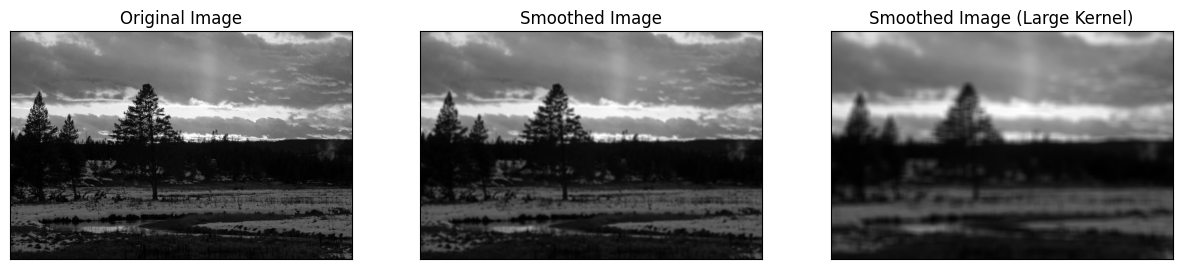

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

img = cv.imread('data/sunset.jpg', 0)

# Create a kernel of 5x5
kernel = np.ones((5,5), np.float32) / 25

# Apply smoothing to the image using the kernel. -1 means that the kernel is applied to all channels of the image.
# In our case we have loaded the image as a grayscale image, so we only need to apply the kernel to the first channel.
smoothed = cv.filter2D(img, -1, kernel) # 

# Let's also apply a larger kernel to compare the effect
kernel2 = np.ones((15,15), np.float32) / 225
smoothed2 = cv.filter2D(img, -1, kernel2)

# Show the results
plt.figure(figsize=(15,5))
titles = ['Original Image', 'Smoothed Image', 'Smoothed Image (Large Kernel)']
images = [img, smoothed, smoothed2]
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

### Gaussian Blurring

In this method, instead of a box filter, a Gaussian kernel is used. The Gaussian kernel is a Gaussian distribution with a standard deviation of 1. The effect of applying a gaussian filter instead of a box filter is that pixels near the center of the image get a higher weight. This is known as **Gaussian Blurring**.

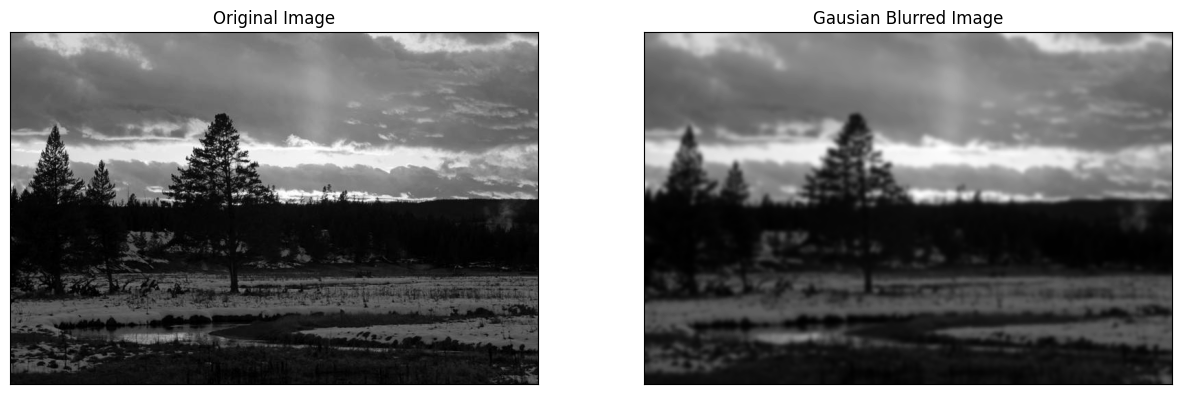

In [3]:
gaussian = cv.GaussianBlur(img, (15,15), 0)

# Show the results
plt.figure(figsize=(15,5))
titles = ['Original Image', 'Gausian Blurred Image']
images = [img, gaussian]
for i in range(2):
    plt.subplot(1, 2, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

To better understand what a Gaussian kernel is, let's see how it looks like.

[[0.   0.01 0.02 0.01 0.  ]
 [0.01 0.06 0.1  0.06 0.01]
 [0.02 0.1  0.16 0.1  0.02]
 [0.01 0.06 0.1  0.06 0.01]
 [0.   0.01 0.02 0.01 0.  ]]


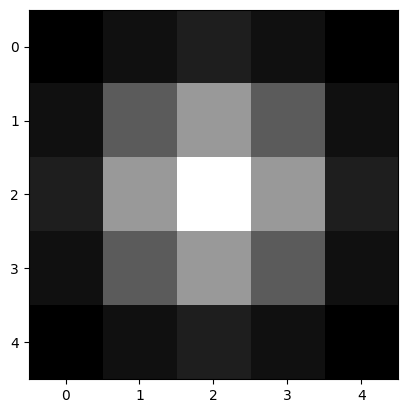

In [4]:
# Generate a 2D Gaussian blurring filter of size (5, 5) with a sigma of 1.
kernel = cv.getGaussianKernel(5, 1)

# The kernel return by the function getGaussianKernel is a vector kernel. To convert it to a 2D matrix,
# we multiply it with its transpose.
kernel = kernel * kernel.T  

# Print the kernel
np.set_printoptions(precision=2)
print(kernel)

# Visualize the kernel as a grayscale image.
plt.imshow(kernel, interpolation='nearest', cmap='gray')

### Why blur?

In our first application of motion detection, setting a low threshold resulted in a lot of white pixels. Those white pixels are caused by noise in the image. On the other hand, we don't want to set the threshold too high, because in that case we will miss some of the pixels of the moving object. So, we need to set a threshold that is a little bit higher than the noise level. Applying blurring to the image will help us to remove the noise and thus be able to set a lower threshold.

Let's repeat that process and apply some blurring to the motion image. We wish show the binary images in both cases without setting the pixels that do not belong the the largest connected component to zero.

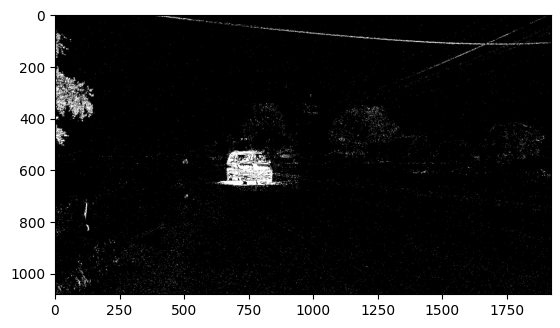

In [5]:
######## Original motion detection process

# Load a video
cap = cv.VideoCapture('./data/Illinois_highway.mp4')

# Extract frame number 5 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 5)
ret, frame5 = cap.read()
# Convert the frame to gray scale
frame5 = cv.cvtColor(frame5, cv.COLOR_BGR2GRAY)

# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)

# Extract frame number 25 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 25)
ret, frame25 = cap.read()
# Convert the frame to gray scale
frame25 = cv.cvtColor(frame25, cv.COLOR_BGR2GRAY)

diff1 = cv.absdiff(frame5, frame15)
diff2 = cv.absdiff(frame15, frame25)

motion = cv.min(diff1, diff2)   # Take the minimum of the two differences

# Threshold the image
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)

# Show the result.
plt.imshow(binary_img, cmap='gray')

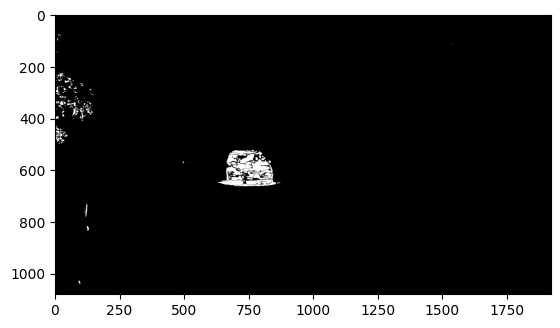

In [6]:
###### Detection process with blurred images

# Extract frame number 5 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 5)
ret, frame5 = cap.read()
# Convert the frame to gray scale
frame5 = cv.cvtColor(frame5, cv.COLOR_BGR2GRAY)
frame5 = cv.GaussianBlur(frame5, (15,15), 0) # Apply a Gaussian blur to the image

# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)
frame15 = cv.GaussianBlur(frame15, (15,15), 0) # Apply a Gaussian blur to the image

# Extract frame number 25 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 25)
ret, frame25 = cap.read()
# Convert the frame to gray scale
frame25 = cv.cvtColor(frame25, cv.COLOR_BGR2GRAY)
frame25 = cv.GaussianBlur(frame25, (15,15), 0) # Apply a Gaussian blur to the image

diff1 = cv.absdiff(frame5, frame15)
diff2 = cv.absdiff(frame15, frame25)

motion = cv.min(diff1, diff2)   # Take the minimum of the two differences

# Apply blurring to motion image
motion_blur = cv.GaussianBlur(binary_img, (15,15), 0)

# Threshold the image
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)

# Show the result.
plt.imshow(binary_img, cmap='gray')

We notice that fewer white pixels are present in the image in which blurring is applied.

### Image Sharpening

Sharpening is the opposite of blurring, and it is a technique that is used to improve the quality of an image. When an image is sharpened, the edges are made more clear. Image sharpening can be achieved in a few different ways. 

One way is to use a sharpening filter like the following:

$$
\text{Sharpening Filter} = \begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0
\end{bmatrix}
$$

Let's see how this works.

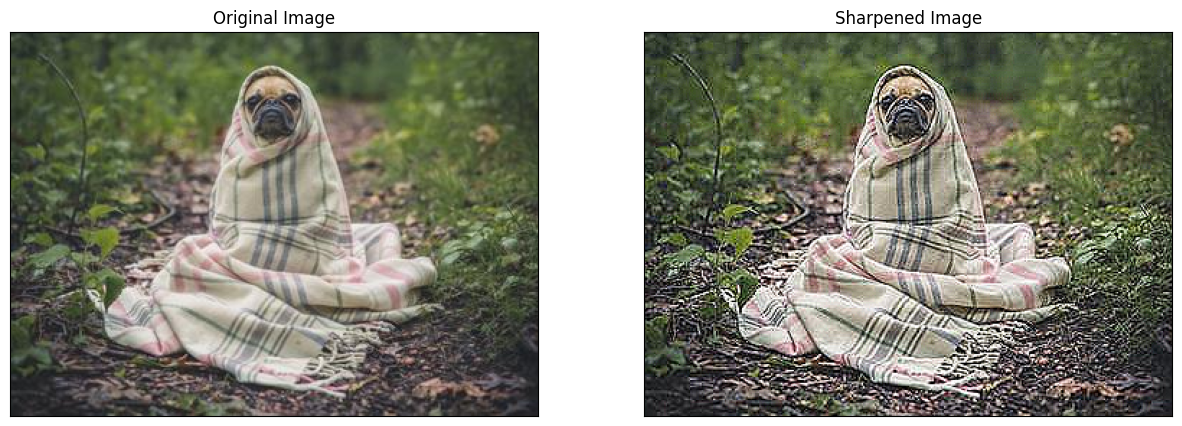

In [7]:
# Load an image
img = cv.imread('data/sharpen.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


### Method1: Sharpen the image by applying a sharpening filter

sharpening_kernel = np.array([[0, -1,  0],
                              [-1,  5, -1],
                              [0, -1,  0]])

sharp_img = cv.filter2D(src=img, ddepth=-1, kernel=sharpening_kernel)

# Show the original and sharpened image
plt.figure(figsize=(15,5))
titles = ['Original Image', 'Sharpened Image']
images = [img, sharp_img]
for i in range(2):
    plt.subplot(1, 2, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

Another way by adding a Gaussian blur to the image and then subtracting the original image from the blurred image. The result of this subtraction is an image that contains the edges of the original image. We can then add this edge image back to the original image multiplied by a factor to make the edges stronger.

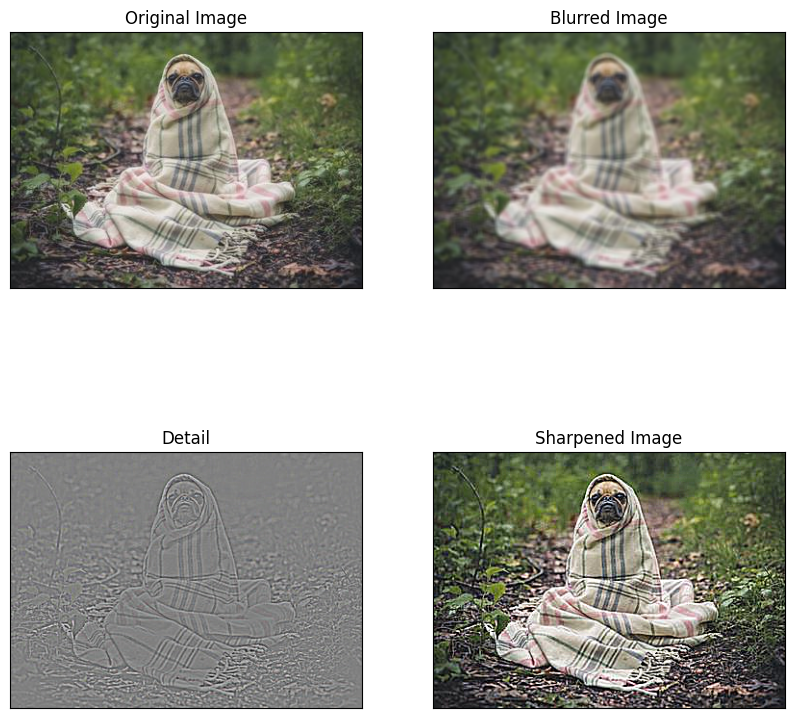

In [8]:
### Method 2: Sharpen the image by subtracting a blurred version of the image from the original image

blurred_img = cv.GaussianBlur(img, (5,5), cv.BORDER_DEFAULT)        # Apply a Gaussian blur to the image

# Subtract the blurred image from the original image. Before we subtract we need to convert the images
# from type uint8 to type int32 to avoid overflow for negative values. 
# Some of the values in the detail image will be negative.
detail = img.astype('int32') - blurred_img.astype('int32') 

# Add the detail image to the original image, multiplied by a factor of 2.
sharp_img = cv.add(img.astype('int'), 2*detail, dtype=cv.CV_8U)

# Normalize the values of the detail image to the range [0, 255] for display.
detail_normalized = cv.normalize(detail, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

# Show the original img, blurred_img, detail_normalized and sharp_img
plt.figure(figsize=(10, 10))
titles = ['Original Image', 'Blurred Image', 'Detail', 'Sharpened Image']
images = [img, blurred_img, detail_normalized, sharp_img]
for i in range(4):
    plt.subplot(2, 2, i+1), plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()